In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

from utils import Cal_Spatial_Net,parse_args,spa_emb_corr
import model.Train as Train
from model.GAE import GAE

### Load Data

load DLPFC 151672 dataset

In [2]:
adata = sc.read_visium(path='./data/151672', count_file='151672_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


load Ground Truth

In [3]:
Ann_df = pd.read_csv('./data/151672/151672_truth.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

### Pre-processing

In [4]:
##normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Visualization of grond truth

... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


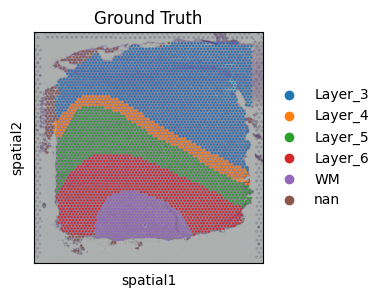

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

### Hyper-parameter Setting

In [6]:
args,_ = parse_args()
args.gt_available = True
args.temperature = 0.4
args.num_centroids = 5
args.n_cluster = 5

set pool_percent

In [7]:
spa_emb_corr = spa_emb_corr(adata)
if spa_emb_corr < -0.25:
    args.pool_percent = 0.95
else:
    args.pool_percent = 0.55

Calculate corr_spa_emb...
Calculating correlation done.


### Graph construction

In [8]:
Cal_Spatial_Net(adata, rad_cutoff=150)

------Calculating spatial graph...
The graph contains 23382 edges, 4015 cells.
5.8237 neighbors per cell on average.


### Training

In [9]:
adata = Train.train(adata, args)

Size of Input:  (4015, 3000)
Training start!


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:13<00:00,  5.43it/s]


### Visualization of conSpaS

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


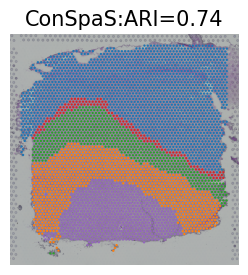

In [10]:
adata.obs['Ground Truth'] = adata.obs['Ground Truth'].replace('nan', np.nan)
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['Ground Truth'], obs_df['kmeans'])
plt.rcParams['font.sans-serif'] = 'Arial'
ax = sc.pl.spatial(adata, color='kmeans', show=False)[0]
plt.title('ConSpaS:ARI=%.2f'%ARI, fontsize=15)
plt.axis('off')
leg = plt.legend()
ax.get_legend().remove()
plt.show()

### UMAP

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


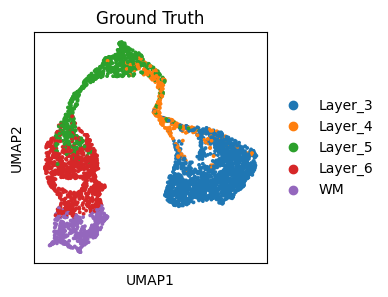

In [11]:
used_adata = adata[adata.obs['Ground Truth'].notna(),:]
sc.pp.neighbors(used_adata,use_rep='rep_norm')
sc.tl.umap(used_adata)
sc.pl.umap(used_adata, color='Ground Truth')

### PAGA

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


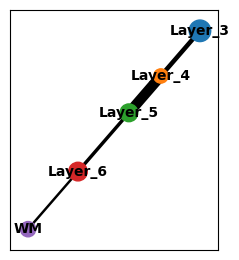

In [12]:
sc.tl.paga(used_adata, groups='Ground Truth')
sc.pl.paga(used_adata, color='Ground Truth')